In [1]:
%load_ext Cython

Iso contour implementation using Cython with a insertion algorithm to merge polygons together.

MarchingSquareCythonInsert
======

In [2]:
%%cython --cplus --compile-args=-std=c++11

import cython
import numpy
cimport numpy as cnumpy

from libcpp.vector cimport vector
from libcpp.list cimport list as clist
from libcpp.unordered_map cimport unordered_map
from libc.math cimport fabs
cdef double EPSILON = numpy.finfo(numpy.float64).eps
from cython.operator cimport dereference
from cython.operator cimport preincrement

cdef cnumpy.int8_t[2] *EDGE_TO_POINT = [[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]]
cdef cnumpy.int8_t[5] *CELL_TO_EDGE = [
                                       # array of index containing
                                       # id0: number of segments (up to 2)
                                       # id1: index of the start of the 1st edge
                                       # id2: index of the end of the 1st edge
                                       # id3: index of the start of the 2nd edge
                                       # id4: index of the end of the 2nd edge
                                       [0, 0, 0, 0, 0],  # Case 0: 0000: nothing
                                       [1, 0, 3, 0, 0],  # Case 1: 0001
                                       [1, 0, 1, 0, 0],  # Case 2: 0010
                                       [1, 1, 3, 0, 0],  # Case 3: 0011

                                       [1, 1, 2, 0, 0],  # Case 4: 0100
                                       [2, 0, 1, 2, 3],  # Case 5: 0101 > ambiguous
                                       [1, 0, 2, 0, 0],  # Case 6: 0110
                                       [1, 2, 3, 0, 0],  # Case 7: 0111

                                       [1, 2, 3, 0, 0],  # Case 8: 1000
                                       [1, 0, 2, 0, 0],  # Case 9: 1001
                                       [2, 0, 3, 1, 2],  # Case 10: 1010 > ambiguous
                                       [1, 1, 2, 0, 0],  # Case 11: 1011

                                       [1, 1, 3, 0, 0],  # Case 12: 1100
                                       [1, 0, 1, 0, 0],  # Case 13: 1101
                                       [1, 0, 3, 0, 0],  # Case 14: 1110
                                       [0, 0, 0, 0, 0],  # Case 15: 1111
                                      ]

ctypedef cnumpy.int64_t hash_index_t

cdef struct point_t:
    cnumpy.float32_t x
    cnumpy.float32_t y

cdef cppclass polygon_description_t:
    hash_index_t begin
    hash_index_t end
    clist[point_t] points

cdef struct next_segment_t:
    int x
    int y
    int index
    int edge


cdef class MarchingSquareCythonInsert(object):
    """Marching square using an insertion algorithm to reconstruct polygons
    on the fly while iterating input data.
    """

    cdef cnumpy.float32_t[:, :] _image
    cdef cnumpy.int8_t[:, :] _mask
    cdef unordered_map[hash_index_t, polygon_description_t*] _polygons

    def __init__(self, image, mask=None):
        self._image = numpy.ascontiguousarray(image, numpy.float32)
        if mask is not None:
            self._mask = numpy.ascontiguousarray(mask, numpy.int8)
            assert(image.shape == mask.shape)
        else:
            self._mask = None
        with nogil:
            # FIXME: Not defined in my cython version...
            # self._polygons.reserve(self._image.shape[1])
            pass

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _marching_squares(self, cnumpy.float64_t isovalue):
        cdef:
            bint do_mask = self._mask is not None
            int dim_y = self._image.shape[0]
            int dim_x = self._image.shape[1]
            int x, y, index
            cnumpy.float64_t tmpf
        with nogil:
            for y in range(dim_y - 1):
                for x in range(dim_x - 1):

                    # Calculate index.
                    index = 0
                    if self._image[y, x] > isovalue:
                        index += 1
                    if self._image[y, x + 1] > isovalue:
                        index += 2
                    if self._image[y + 1, x + 1] > isovalue:
                        index += 4
                    if self._image[y + 1, x] > isovalue:
                        index += 8

                    # Resolve ambiguity
                    if index == 5 or index == 10:
                        # Calculate value of cell center (i.e. average of corners)
                        tmpf = 0.25 * (self._image[y, x] +
                                       self._image[y, x + 1] +
                                       self._image[y + 1, x] +
                                       self._image[y + 1, x + 1])
                        # If below isovalue, swap
                        if tmpf <= isovalue:
                            if index == 5:
                                index = 10
                            else:
                                index = 5

                    # Cache mask information
                    if do_mask:
                        if self._mask[y, x] > 0:
                            index += 16
                        if self._mask[y, x + 1] > 0:
                            index += 32
                        if self._mask[y + 1, x + 1] > 0:
                            index += 64
                        if self._mask[y + 1, x] > 0:
                            index += 128

                    if index < 16 and index != 0 and index != 15:
                        with gil:
                            self._insert_pattern(x, y, index, isovalue)

    cdef void _insert_pattern(self, int x, int y, int pattern, cnumpy.float64_t isovalue):
        cdef:
            int segment
        for segment in range(CELL_TO_EDGE[pattern][0]):
            begin_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 0]
            end_edge = CELL_TO_EDGE[pattern][1 + segment * 2 + 1]
            self._insert_segment(x, y, begin_edge, end_edge, isovalue)

    cdef hash_index_t _create_hash_index(self, int x, int y, cnumpy.uint8_t edge):
        """Create an identifier for a tuple x-y-edge (which is reversible)

        There is no way to create hashable struct in cython. Then it uses
        a standard hashable type.

        For example, the tuple (x=0, y=0, edge=2) is equal to (x=1, y=0, edge=0)
        """
        cdef:
            hash_index_t v = 0
        if edge == 2:
            y += 1
            edge = 0
        elif edge == 3:
            x -= 1
            edge = 1
        # Avoid negative values
        x += 1
        y += 1

        v += edge
        v <<= 3
        v += x
        v <<= 24
        v += y
        return v

    cdef void _insert_segment(self,
                              int x, int y,
                              cnumpy.uint8_t begin_edge,
                              cnumpy.uint8_t end_edge,
                              cnumpy.float64_t isovalue):
        cdef:
            int i
            point_t point
            hash_index_t begin, end
            polygon_description_t *description
            polygon_description_t *description_begin
            polygon_description_t *description_end
            unordered_map[hash_index_t, polygon_description_t*].iterator it_begin
            unordered_map[hash_index_t, polygon_description_t*].iterator it_end

        begin = self._create_hash_index(x, y, begin_edge)
        end = self._create_hash_index(x, y, end_edge)

        it_begin = self._polygons.find(begin)
        it_end = self._polygons.find(end)
        if it_begin == self._polygons.end() and it_end == self._polygons.end():
            # insert a new polygon
            description = new polygon_description_t()
            description.begin = begin
            description.end = end
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description.points.push_back(point)
            self._compute_point(x, y, end_edge, isovalue, &point)
            description.points.push_back(point)
            self._polygons[begin] = description
            self._polygons[end] = description
        elif it_begin == self._polygons.end():
            # insert the beggining point to an existing polygon
            self._compute_point(x, y, begin_edge, isovalue, &point)
            description = dereference(it_end).second
            if end == description.begin:
                # insert at start
                description.points.push_front(point)
                self._polygons.erase(description.begin)
                description.begin = begin
                self._polygons[begin] = description
            else:
                # insert on tail
                description.points.push_back(point)
                self._polygons.erase(description.end)
                description.end = begin
                self._polygons[begin] = description
        elif it_end == self._polygons.end():
            # insert the endding point to an existing polygon
            self._compute_point(x, y, end_edge, isovalue, &point)
            description = dereference(it_begin).second
            if begin == description.begin:
                # insert at start
                description.points.push_front(point)
                self._polygons.erase(description.begin)
                description.begin = end
                self._polygons[end] = description
            else:
                # insert on tail
                description.points.push_back(point)
                self._polygons.erase(description.end)
                description.end = end
                self._polygons[end] = description
        else:
            # merge 2 polygons using this segment
            description_begin = dereference(it_begin).second
            description_end = dereference(it_end).second
            if description_begin == description_end:
                # The segment closes a polygon
                # FIXME: this intermediate assign is not needed
                point = description_begin.points.front()
                description_begin.points.push_back(point)
                self._polygons.erase(description_begin.end)
                description_begin.end = description_begin.begin
                # TODO: Should it be removed from the polygons map?
            else:
                if ((begin == description_begin.begin or end == description_begin.begin) and
                   (begin == description_end.end or end == description_end.end)):
                    # worst case, let's make it faster
                    description = description_end
                    description_end = description_begin
                    description_begin = description

                # FIXME: We can recycle a description instead of creating a new one
                description = new polygon_description_t()

                # Make sure the last element of the list is the one to connect
                if description_begin.begin == begin or description_begin.begin == end:
                    # O(n)
                    description_begin.points.reverse()
                    description.begin = description_begin.end
                else:
                    description.begin = description_begin.begin

                # O(1)
                description.points.splice(description.points.end(), description_begin.points)

                # Make sure the first element of the list is the one to connect
                if description_end.end == begin or description_end.end == end:
                    description_end.points.reverse()
                    description.end = description_end.begin
                else:
                    description.end = description_end.end

                description.points.splice(description.points.end(), description_end.points)

                self._polygons.erase(begin)
                self._polygons.erase(end)
                self._polygons[description.begin] = description
                self._polygons[description.end] = description

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef void _compute_point(self,
                             cnumpy.uint_t x,
                             cnumpy.uint_t y,
                             cnumpy.uint8_t edge,
                             cnumpy.float64_t isovalue,
                             point_t *result_point):
        cdef:
            int dx1, dy1, dx2, dy2
            cnumpy.float64_t fx, fy, ff, weight1, weight2
        # Use these to look up the relative positions of the pixels to interpolate
        dx1, dy1 = EDGE_TO_POINT[edge][0], EDGE_TO_POINT[edge][1]
        dx2, dy2 = EDGE_TO_POINT[edge + 1][0], EDGE_TO_POINT[edge + 1][1]
        # Define "strength" of each corner of the cube that we need
        weight1 = 1.0 / (EPSILON + fabs(self._image[y + dy1, x + dx1] - isovalue))
        weight2 = 1.0 / (EPSILON + fabs(self._image[y + dy2, x + dx2] - isovalue))
        # Apply a kind of center-of-mass method
        fx, fy, ff = 0.0, 0.0, 0.0
        fx += dx1 * weight1
        fy += dy1 * weight1
        ff += weight1
        fx += dx2 * weight2
        fy += dy2 * weight2
        ff += weight2
        fx /= ff
        fy /= ff
        result_point.x = x + fx
        result_point.y = y + fy

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    cdef _extract_polygons(self):
        cdef:
            int i, i_pixel
            cnumpy.uint8_t index
            unordered_map[hash_index_t, polygon_description_t*].iterator it
            vector[polygon_description_t*] descriptions
            clist[point_t].iterator it_points
            polygon_description_t *description
        polygons = []
        with nogil:
            it = self._polygons.begin()
            while it != self._polygons.end():
                description = dereference(it).second
                if dereference(it).first == description.begin:
                    # polygones are stored 2 times
                    # only use one
                    descriptions.push_back(description)
                preincrement(it)
        self._polygons.clear()

        # clean up allocated memory
        for i in range(descriptions.size()):
            description = descriptions[i]
            polygon = numpy.empty(description.points.size() * 2, dtype=numpy.float32)
            it_points = description.points.begin()
            i_pixel = 0
            while it_points != description.points.end():
                polygon[i_pixel + 0] = dereference(it_points).x
                polygon[i_pixel + 1] = dereference(it_points).y
                i_pixel += 2
                preincrement(it_points)
            polygon.shape = -1, 2
            polygons.append(polygon)
            del description
        return polygons

    @cython.boundscheck(False)
    @cython.wraparound(False)
    @cython.cdivision(True)
    def iso_contour(self, value=None):
        self._marching_squares(value)
        polygons = self._extract_polygons()
        return polygons

ThisMarchingSquare = MarchingSquareCythonInsert

Test
====

In [3]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 1],
                     [0, 0, 1, 0, 0, 1],
                     [0, 0, 0, 0, 0, 1]], dtype=numpy.float32)

algo = ThisMarchingSquare(image)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[2.5, 2. ],
       [2. , 1.5],
       [1.5, 2. ],
       [2. , 2.5],
       [2.5, 2. ]], dtype=float32), array([[5. , 0.5],
       [4.5, 1. ],
       [4.5, 2. ],
       [4.5, 3. ]], dtype=float32), array([[1.5, 1. ],
       [1. , 0.5],
       [0.5, 1. ],
       [1. , 1.5],
       [1.5, 1. ]], dtype=float32)]


In [4]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 1, 0, 0],
                     [0, 1, 1, 1, 1, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=numpy.float32)

algo = ThisMarchingSquare(image)
polygons = algo.iso_contour(value=0.5)
print(polygons)

[array([[2. , 3.5],
       [1.5, 3. ],
       [1. , 2.5],
       [0.5, 2. ],
       [1. , 1.5],
       [1.5, 1. ],
       [2. , 0.5],
       [3. , 0.5],
       [3.5, 1. ],
       [4. , 1.5],
       [4.5, 2. ],
       [4. , 2.5],
       [3. , 2.5],
       [2.5, 3. ],
       [2. , 3.5]], dtype=float32)]


Utils
=====

In [5]:
%matplotlib nbagg

In [6]:
class MarchingSquareSciKitImage(object):

    def __init__(self, image, mask=None):
        import skimage.measure
        self._image = image
        self._mask = mask
        x, y = numpy.mgrid[:self._image.shape[0], :self._image.shape[1]]

    _deltas = [(0.0, 0.0), (0.99, 0.0), (0.0, 0.99), (0.99, 0.99)]

    def _flag_coord_over_mask(self, coord):
        """Flag coord over the mask as NaN"""
        for dx, dy in self._deltas:
            if self._mask[int(coord[0] + dx), int(coord[1] + dy)] != 0:
                return float("nan"), float("nan")
        return coord

    def iso_contour(self, value):
        import skimage.measure
        polylines = skimage.measure.find_contours(self._image, level=value)
        result = []
        for polyline in polylines:
            if self._mask is not None:
                polyline = map(self._flag_coord_over_mask, polyline)
                polyline = list(polyline)
                polyline = numpy.array(polyline)
            # swap x and y columns
            polyline = numpy.array([polyline[:,1], polyline[:,0]]).T
            result.append(polyline)
        return result

In [7]:
def plot_problem(problem, marching_square):
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    import matplotlib.pyplot as plt
    matplotlib.interactive(True)

    fig, ax = plt.subplots()
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    ax.set_ylim([0, problem.image.shape[0]])
    ax.set_xlim([0, problem.image.shape[1]])
    ax.invert_yaxis()

    # image
    plt.imshow(problem.image, cmap="Greys", alpha=.5)
    
    # mask
    mask = numpy.ma.masked_where(problem.mask == 0, problem.mask)
    plt.imshow(mask, cmap="cool", alpha=.5)

    # iso contours
    colors = ["#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"]
    for ivalue, value in enumerate(problem.values):
        color = colors[ivalue % len(colors)]
        polygons = marching_square.iso_contour(value)
        for p in polygons:
            p = Polygon(p, fill=False, edgecolor=color, closed=False)
            ax.add_patch(p)

    plt.show()

In [8]:
import numpy
import collections
import os

Problem = collections.namedtuple("Problem", ["image", "mask", "values"])

ROOT = os.getcwd()

def create_test_problem():
    import fabio
    data = fabio.open(ROOT + "/data/data.tif").data
    mask = fabio.open(ROOT + "/data/mask.tif").data
    mask = mask == 0
    values = range(10, 1000, int(240/6))[0:7]
    return Problem(data, mask, values)

def create_wos_problem():
    # Problem containing a WOS XPad with pixel displacment and mask
    import fabio
    data = numpy.load(ROOT + "/data/wos_tth.npz")
    image = data["tth"]
    mask = fabio.open(ROOT + "/data/wos_mask.edf").data
    mask = (mask != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_17_problem():
    # Problem containing an image of 4096x4096 with 17 rings
    data = numpy.load(ROOT + "/data/id22_17.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_1441_problem():
    # Problem containing an image of 4096x4096 with 1441 rings
    data = numpy.load(ROOT + "/data/id22_1441.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

Test without mask
=================

In [9]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

116 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
55 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Test with mask
==============

In [10]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]

377 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
66.2 ms ± 945 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


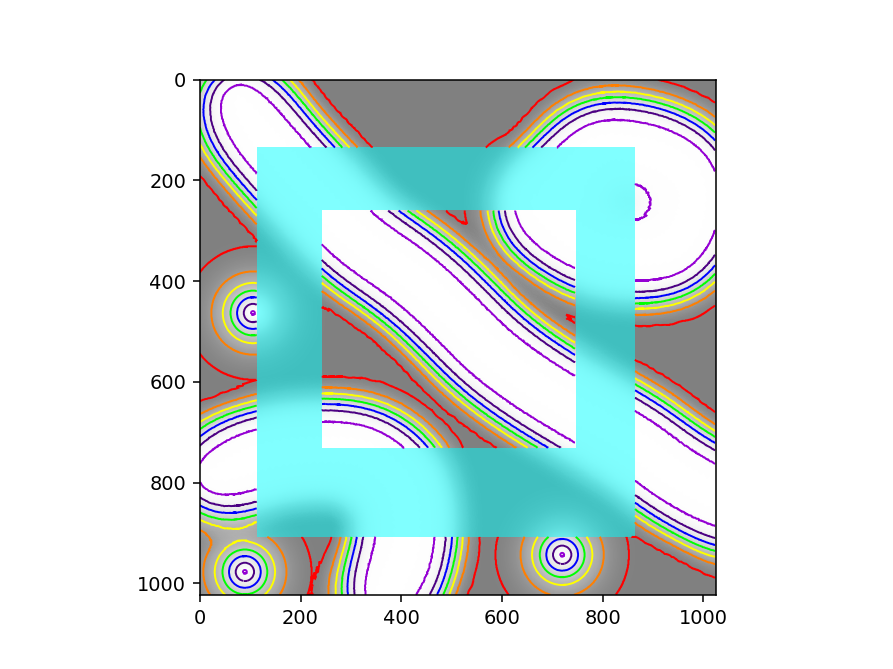

In [11]:
problem = create_test_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)

WOS detector (700K pixels)
==========================

In [12]:
problem = create_wos_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
489 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
50.3 ms ± 944 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Without mask
129 ms ± 415 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
57.3 ms ± 579 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


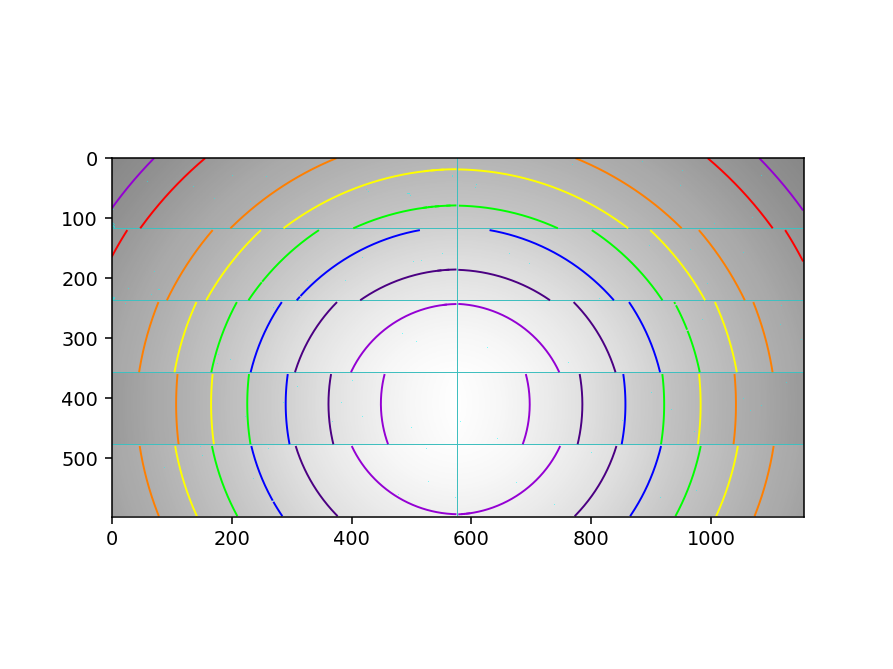

In [13]:
problem = create_wos_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)

Perkin Elmer (16M pixels)
===================

In [14]:
problem = create_id22_17_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]
marching_square = ThisMarchingSquare(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
1.94 s ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.16 s ± 5.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Without mask
1.65 s ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.46 s ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


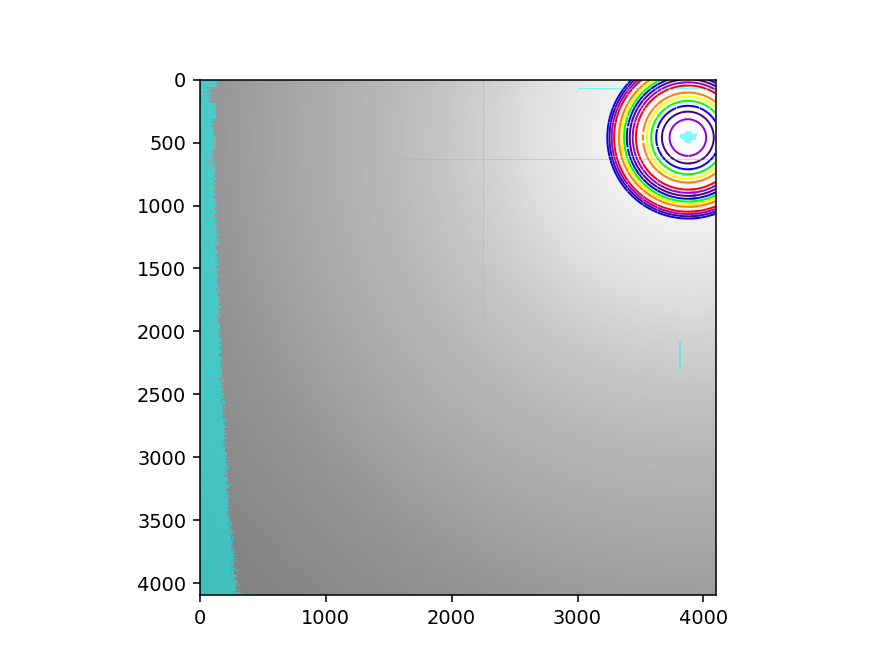

In [15]:
problem = create_id22_17_problem()
marching_square = ThisMarchingSquare(problem.image, problem.mask)
plot_problem(problem, marching_square)